In [1]:
import numpy as np
import pandas as pd
import os
import csv
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.calibration import calibration_curve
from scipy.stats import mstats
from scipy.stats.mstats import winsorize
from scipy import stats
from pyampute.ampute import MultivariateAmputation
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from lifelines import CoxPHFitter, WeibullFitter, WeibullAFTFitter
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from datetime import datetime, date, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from os.path import isfile, join
from sklearn.metrics import mean_absolute_error, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.gam.tests.test_penalized import df_autos
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from scipy.spatial import distance
from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from time import time
from sksurv.ensemble import RandomSurvivalForest
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score)
from sksurv.metrics import brier_score
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from data import load_dataset 
from sklearn.metrics import make_scorer
from sksurv.metrics import concordance_index_censored
from sklearn.pipeline import Pipeline
import warnings 
warnings.filterwarnings('ignore')
from sklearn.isotonic import IsotonicRegression


drive = 'H'
main_path = drive + ':/Shared drives/CKD_Progression/data/CKD_COHORT_Jan2010_Mar2024_v3.csv'
data_path = drive + ':/Shared drives/CKD_Progression/data/'
docs_path = drive + ':/Shared drives/CKD_Progression/docs/'
save_path = drive + ':/Shared drives/CKD_Progression/save/'
resu_path = drive + ':/Shared drives/CKD_Progression/result/'
covariates_path = docs_path + 'covariates.csv'
removecols_path = docs_path + 'remove_columns.csv'

plt.rcParams['font.family'] = 'Arial'
covariates, order_covariates, long_df = load_dataset(get_columns = True)

def concordance_scorer(y_true, y_pred):
    events = y_true['event']
    times  = y_true['time']
    return concordance_index_censored(events, times, y_pred)[0]

def concordance_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return concordance_index_censored(y['status'], y['time'], y_pred)[0]

def brier_score_scorer(estimator, X, y):
    y_pred = estimator.predict_survival_function(X)
    return brier_score(y['status'], y['time'], y_pred, time_point = 1)

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

def calculate_nll_loss(model, X, y_true):
    survival_probs = model.predict_survival_function(X)  
    nll = 0  
    for i, fn in enumerate(survival_probs):
        time_at_event = y_true['time'][i]
        if time_at_event <= 0:
            continue 
        prob_of_survival = fn(time_at_event)
        event_status = y_true['status'][i]
        if event_status:
            nll -= np.log(1 - prob_of_survival)
        else:
            nll -= np.log(prob_of_survival)
    return nll / len(survival_probs) 

def calculate_median_survival_time(surv_func):
    for t, prob in zip(surv_func.x, surv_func.y):
        if prob <= 0.5:
            return t
    return surv_func.x[-1] 

def calculate_cindex(model, X, y_true):
    surv_funcs = model.predict_survival_function(X) 
    times = y_true['time']
    events = y_true['status']
    predicted_survival_times = np.array([calculate_median_survival_time(fn) for fn in surv_funcs])
    c_index = concordance_index_censored(events.astype(bool), times, predicted_survival_times)[0]
    return c_index

def permutation_importance_rsf(model, X, y, metric_func, n_repeats = 2, random_state = None):
    rng = np.random.RandomState(random_state)
    baseline_score = metric_func(model, X, y)  
    scores = np.zeros((n_repeats, X.shape[1]))

    for i in tqdm(range(X.shape[1])):  
        X_permuted = X.copy()
        for n in range(n_repeats):  
            X_permuted[:, i] = rng.permutation(X[:, i])  
            permuted_score = metric_func(model, X_permuted, y)  
            scores[n, i] = permuted_score - baseline_score  
    importances_mean = np.mean(scores, axis = 0)
    importances_std  = np.std(scores,  axis = 0)
    return importances_mean, importances_std

def adaptive_calibration_error(y_true, y_pred, num_bins=10):
    sorted_indices = np.argsort(y_pred)
    sorted_y_pred = y_pred[sorted_indices]
    sorted_y_true = y_true[sorted_indices]

    bin_size = len(y_pred) // num_bins
    bins = [sorted_y_pred[i * bin_size:(i + 1) * bin_size] for i in range(num_bins)]
    true_bins = [sorted_y_true[i * bin_size:(i + 1) * bin_size] for i in range(num_bins)]
    
    calibration_error = 0.0
    for i in range(num_bins):
        mean_pred = np.mean(bins[i])
        mean_true = np.mean(true_bins[i])
        bin_error = np.abs(mean_pred - mean_true)
        calibration_error += bin_error * len(bins[i]) / len(y_pred)
    return calibration_error

def nonconformity_score(predicted_risk, true_status):
    return np.abs(predicted_risk - true_status)

def get_calibration_plot(y_test, y_calib, calibrated, prediction, pathway, folder_name):
    fraction_of_positives,  mean_predicted_value = calibration_curve(y_calib['status'], calibrated, n_bins = 20)
    fraction_of_prediction, mean_predicted_preds = calibration_curve( y_test['status'], prediction, n_bins = 20)
    inner, outer = pathway.split('_')[0], pathway.split('_')[2]
    plt.figure(figsize = (7, 6))
    plt.plot(mean_predicted_value, fraction_of_positives,  marker = 'o', markersize = 8, c = 'b', label = 'Calibrated')
    plt.plot(mean_predicted_preds, fraction_of_prediction, marker = 'o', markersize = 8, c = 'r', label = 'Uncalibrated')

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')

    plt.xlabel('Mean Predicted Probability', size = 15)
    plt.ylabel('Fraction of Positives', size = 15)
    plt.title(f'{inner} to {outer} Calibration Plot', size = 18)
    plt.legend()

    folder_path = resu_path + f'modeling/gradientboosting/calibration_plot/{folder_name}/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(os.path.join(folder_path, f'calibration_{pathway}.png'))

def compute_brier_score_in_batches(model, X_test, y_test, y_train, time_grid, batch_size=100):
    brier_scores = []
    n_batches = int(np.ceil(len(X_test) / batch_size))

    for i in range(n_batches):
        X_batch = X_test[i * batch_size : (i + 1) * batch_size]
        y_batch = y_test[i * batch_size : (i + 1) * batch_size]

        surv_preds = model.predict_survival_function(X_batch)
        prediction_prob = np.array([fn(time_grid) for fn in surv_preds])
        brier_score = integrated_brier_score(
            y_train, y_batch, prediction_prob, time_grid)
        brier_scores.append(brier_score)
    return np.mean(brier_scores, axis = 0)

def extract_survival_probabilities(predictions, time_grid):
    prob_arrays = []
    for pred in predictions:
        probs = np.array([pred.get(t, 0) for t in time_grid]) 
        prob_arrays.append(probs)
    return np.array(prob_arrays)

concordance_scorer = make_scorer(concordance_scorer, greater_is_better = True)
brier_score_scorer = make_scorer(brier_score_scorer, greater_is_better = True)

c:\Users\student1\.conda\envs\sam\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def filter_covariates(multivariate_covariates, pathway):
    ckd_related_vars = [
        'cho_normal', 'cho_high', 'tri_normal', 'tri_high',
        'glu_normal', 'glu_impaired', 'glu_high', 'hba_normal',
        'hba_prediabetes', 'hba_high', 'sglt2'
    ]
    
    general_vars = [
        'gender', 'age_less60', 'age_geq60',
        'cho_normal', 'cho_high', 'tri_normal', 'tri_high',
        'glu_normal', 'glu_impaired', 'glu_high', 'hba_normal',
        'hba_prediabetes', 'hba_high', 'sglt2'
    ]
    
    if pathway.lower().endswith('ckd'):
        filtered_covariates = [var for var in multivariate_covariates if var not in ckd_related_vars]
    else:
        filtered_covariates = [var for var in multivariate_covariates if var not in general_vars]
    
    return filtered_covariates

In [3]:
def main_gradient_boost(folder_name, get_variance_inflation, get_interaction, get_importance, use_conformal, use_platt, save_variance):
    log_file = resu_path + f'modeling/gradientboosting/gbm_results_log_{folder_name}.csv'
    if not os.path.exists(log_file):
        with open(log_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['pathway', 'best_params', 'fit_predict_time', 'covariates', 'num_covariates',
                             'survival_auc', 'survival_mauc', 'c_index', 'c_index_cal', 'brier', 'brier_cal', 'ace', 'coverage'])

    pathways = long_df['pathway'].unique().tolist()
    for path in ['CKD3A_to_DEAD', 'CKD3A_to_CKD4', 'CKD3A_to_CKD5A', 'CKD3A_to_CKD5B', 'CKD3B_to_CKD5A', 'CKD3B_to_CKD5B', 'CKD4_to_CKD5B']:
        pathways.remove(path)

    scaler = MinMaxScaler()
    multicollinear_threshold = 10
    for pathway in tqdm(pathways):
        print(f'Processing pathway: {pathway}')
        if 'CKD' in pathway.split('_')[0] and 'CKD' in pathway.split('_')[2]:
            sheet_pathway = 'CKD_to_CKD'
        elif 'CKD' in pathway.split('_')[0] and 'CVD' in pathway.split('_')[2]:
            sheet_pathway = 'CKD_to_CVD'
        else:
            sheet_pathway = 'CKD_to_CKD'

        transition_df = long_df[long_df['pathway'] == pathway]

        univariate  = pd.read_excel(resu_path + f'univariate/LR_test/{pathway}.xlsx')
        interaction = pd.read_excel(resu_path + f'univariate/univariate_interaction.xlsx', sheet_name=sheet_pathway)
        multivariate_covariates = univariate[univariate['pvalue'] < 0.20]['variable'].tolist()
        multivariate_primary    = univariate[univariate['pvalue'] < 0.20]['variable'].tolist()
        # multivariate_covariates = filter_covariates(multivariate_covariates, pathway)

        if get_variance_inflation:
            if get_interaction:
                multivariate_covariates_set = set(multivariate_covariates)
                univariate_predictors = list(set(interaction['predictor1'].unique().tolist() + interaction['predictor2'].unique().tolist()))
                for index, row in interaction.iterrows():
                    interaction_name = row['variable']
                    predictor1 = row['predictor1']
                    predictor2 = row['predictor2']

                    transition_df[interaction_name] = transition_df[predictor1] * transition_df[predictor2]
                    multivariate_covariates_set.discard(predictor1)
                    multivariate_covariates_set.discard(predictor2)
                multivariate_covariates_set.update(interaction['variable'].tolist())
                multivariate_covariates = list(multivariate_covariates_set)
                multivariate_covariates = list(set(multivariate_primary + multivariate_covariates))

            remove_features = pd.read_csv(resu_path + f'/modeling/gradientboosting/feature_importance/{folder_name}/{pathway}.csv')
            remove_features = remove_features[remove_features['importance_mean'] <= 0]['feature'].unique().tolist()

            X = transition_df[multivariate_covariates]
            X_scaled = scaler.fit_transform(X)
            X_scaled_df = pd.DataFrame(X_scaled, columns=multivariate_covariates)
            vif_result = calculate_vif(X_scaled_df)
            if save_variance:
                folder_path = resu_path + f'modeling/gradientboosting/variance_inflation/{folder_name}/'
                if not os.path.exists(folder_path):
                    os.mkdir(folder_path)
                vif_result.to_csv(os.path.join(folder_path, f'{pathway}.csv'), index=False)
            multicollinear = vif_result[vif_result['VIF'] >= multicollinear_threshold]['variable'].tolist()
            multivariate_covariates = vif_result[vif_result['VIF'] < multicollinear_threshold]['variable'].tolist()
            print(f'There are {len(multicollinear)} covariates with high multicollinearity.')

        independent_df = transition_df.drop(columns=['status'])
        independent_df = transition_df[multivariate_covariates]
        groundtruth_df = transition_df[['status', 'time']]
        groundtruth_df['status'] = groundtruth_df['status'].astype(bool)
        groundtruth_df['time'] = pd.to_numeric(groundtruth_df['time'])

        censored_weight = len(groundtruth_df) / groundtruth_df['status'].value_counts()[0]
        event_weight = len(groundtruth_df) / groundtruth_df['status'].value_counts()[1]

        groundtruth_df['sample_weight'] = groundtruth_df['status'].apply(lambda x: event_weight if x else censored_weight)

        X, y = independent_df, Surv.from_dataframe('status', 'time', groundtruth_df)
        X_train, X_test, y_train, y_test, sample_weight_train, sample_weight_test = train_test_split(X, y, groundtruth_df['sample_weight'].to_numpy(), test_size=0.30, random_state=42)
        X_train, X_calib, y_train, y_calib, sample_weight_train, sample_weight_calib = train_test_split(
            X_train, y_train, sample_weight_train, test_size = 0.20, random_state=42)

        X_train = scaler.fit_transform(X_train)

        param_grid = {
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [50, 100, 300],
            'max_depth': [3, 5, None],
            'min_samples_split': [2, 3],
            'min_samples_leaf': [1, 2]}

        start = time()
        gbm = GradientBoostingSurvivalAnalysis(random_state = 42)

        survival_forest = RandomizedSearchCV(gbm,
                                             param_grid,
                                             cv = 5,
                                             n_iter  = 2,
                                             scoring = 'neg_brier_score')

        
        survival_forest.fit(X_train, y_train, sample_weight = sample_weight_train)
        best_survival = survival_forest.best_estimator_
        fit_predict_time = np.round(time() - start, 3)

        period_max = 100
        times = np.arange(y_test['time'].min(), period_max, 12)
        
        risk_score = best_survival.predict(X_calib) 
        surv_preds = best_survival.predict_survival_function(X_calib)
        prediction = [fn(period_max) for fn in surv_preds]

        if use_platt:
            risk_score = risk_score.reshape(-1, 1)
            risk_score_scaled = scaler.fit_transform(risk_score)
            platt_scaler = LogisticRegression()
            platt_scaler.fit(risk_score_scaled, y_test['status'])
            calibrated = platt_scaler.predict_proba(risk_score_scaled)[:, 1]

        else:
            iso_reg = IsotonicRegression(out_of_bounds = 'clip')
            iso_reg.fit(risk_score, y_calib['status'])

            risk_score_test = best_survival.predict(X_test)
            calibrated = iso_reg.transform(risk_score_test)
            
        if use_conformal:
            X_calib = scaler.transform(X_calib)

            calib_risk_scores = best_survival.predict(X_calib)
            nonconformity_scores = nonconformity_score(calib_risk_scores, y_calib['status'])
            quantile_value = np.quantile(nonconformity_scores, 1 - 0.05)

            lower_bound = risk_score - quantile_value
            upper_bound = risk_score + quantile_value

            covered  = np.logical_and(y_calib['status'] >= lower_bound, y_calib['status'] <= upper_bound)
            coverage = np.mean(covered)
            print(f'Coverage: {coverage * 100:.2f}%')
        else:
            coverage = np.NaN

        time_grid = np.linspace(1, period_max, 1000)
        surv_preds_test = best_survival.predict_survival_function(X_test)

        prediction_prob = np.array([fn(time_grid) for fn in surv_preds_test])
        calibrated_prob = np.tile(calibrated[:, np.newaxis], (1, len(time_grid)))

        y_train_df = pd.DataFrame(y_train, columns = ['status', 'time'])
        y_tests_df = pd.DataFrame(y_test,  columns = ['status', 'time'])
        y_train_surv = Surv.from_dataframe('status', 'time', y_train_df)
        y_tests_surv = Surv.from_dataframe('status', 'time', y_tests_df)

        survival_auc,   survival_mauc = cumulative_dynamic_auc(y_train, y_test,  risk_score_test, times)
        survival_auc  = survival_auc[~np.isnan(survival_auc)]
        survival_mauc = np.mean(survival_mauc)
         
        c_index     = concordance_index_censored( y_test['status'],  y_test['time'], risk_score_test)[0] 
        c_index_cal = concordance_index_censored(y_calib['status'], y_calib['time'], risk_score)[0] 
        brier_score_val = integrated_brier_score(y_train_surv, y_tests_surv, prediction_prob, time_grid)
        brier_score_cal = integrated_brier_score(y_train_surv, y_tests_surv, calibrated_prob, time_grid)
        ace_value = adaptive_calibration_error(y_test['status'], calibrated)

        with open(log_file, mode = 'a', newline = '') as file:
            writer = csv.writer(file)
            writer.writerow([pathway,
                            best_survival.get_params(),
                            fit_predict_time,
                            multivariate_covariates,
                            len(multivariate_covariates),
                            survival_auc,
                            survival_mauc,
                            c_index,
                            c_index_cal,
                            brier_score_val,
                            brier_score_cal,
                            ace_value,
                            coverage])
        print(f'\tFit and predict time of SGB at transition {pathway}: {fit_predict_time} seconds with {len(multivariate_covariates)} covariates.')
        print(f'\tC-index: {np.round(c_index, 2)} \tC-index (cal): {np.round(c_index_cal, 2)} \tBS: {np.round(brier_score_val/2, 2)} \tCBS: {np.round(brier_score_cal/10, 2)} \tACE: {np.round(ace_value, 5)}')

        prediction = [1 - p for p in prediction] 
        get_calibration_plot(y_calib, y_test, calibrated, prediction, pathway, folder_name)

        if get_importance:
            importances_mean, importances_std = permutation_importance_rsf(best_survival,
                                                                           X_test.values, y_test,
                                                                           calculate_cindex,  
                                                                           n_repeats = 10, 
                                                                           random_state = 42)
            feature_importance_df = pd.DataFrame({'feature': X_test.columns, 'importance_mean': importances_mean, 'importance_std' : importances_std})
            feature_importance_df = feature_importance_df.sort_values(by =   'importance_mean', ascending = False)
            
            folder_path = resu_path + f'modeling/gradientboosting/feature_importance/{folder_name}/'
            if not os.path.exists(folder_path):
                os.mkdir(folder_path)  
            feature_importance_df.to_csv(os.path.join(folder_path, f'{pathway}.csv'), index = False)

  0%|          | 0/18 [00:00<?, ?it/s]

Processing pathway: CKD3A_to_CKD3B
Coverage: 98.32%
	Fit and predict time of SGB at transition CKD3A_to_CKD3B: 1227.523 seconds with 20 covariates.
	C-index: 0.64 	C-index (cal): 0.65 	BS: 0.11 	CBS: 0.03 	ACE: 0.02377


  6%|▌         | 1/18 [27:47<7:52:35, 1667.96s/it]

Processing pathway: CKD3A_to_CVD
Coverage: 95.00%
	Fit and predict time of SGB at transition CKD3A_to_CVD: 2130.389 seconds with 23 covariates.
	C-index: 0.61 	C-index (cal): 0.58 	BS: 0.06 	CBS: 0.04 	ACE: 0.01433


 11%|█         | 2/18 [1:11:56<9:58:40, 2245.03s/it]

Processing pathway: CVD_to_CKD3B
Coverage: 95.10%
	Fit and predict time of SGB at transition CVD_to_CKD3B: 50.79 seconds with 12 covariates.
	C-index: 0.58 	C-index (cal): 0.56 	BS: 0.14 	CBS: 0.05 	ACE: 0.02391


 17%|█▋        | 3/18 [1:13:24<5:14:58, 1259.88s/it]

Processing pathway: CVD_to_CKD4
Coverage: 94.95%
	Fit and predict time of SGB at transition CVD_to_CKD4: 138.366 seconds with 13 covariates.
	C-index: 0.59 	C-index (cal): 0.61 	BS: 0.07 	CBS: 0.08 	ACE: 0.01619


 22%|██▏       | 4/18 [1:17:27<3:20:16, 858.33s/it] 

Processing pathway: CVD_to_CKD5A
Coverage: 96.22%
	Fit and predict time of SGB at transition CVD_to_CKD5A: 647.216 seconds with 14 covariates.
	C-index: 0.64 	C-index (cal): 0.44 	BS: 0.02 	CBS: 0.1 	ACE: 0.00616


 28%|██▊       | 5/18 [1:30:04<2:58:03, 821.80s/it]

Processing pathway: CVD_to_CKD5B
Coverage: 95.28%
	Fit and predict time of SGB at transition CVD_to_CKD5B: 202.125 seconds with 10 covariates.
	C-index: 0.53 	C-index (cal): 0.55 	BS: 0.0 	CBS: 0.1 	ACE: 0.00383


 33%|███▎      | 6/18 [1:34:50<2:07:56, 639.67s/it]

Processing pathway: CVD_to_DEAD
Coverage: 95.49%
	Fit and predict time of SGB at transition CVD_to_DEAD: 124.622 seconds with 13 covariates.
	C-index: 0.59 	C-index (cal): 0.74 	BS: 0.02 	CBS: 0.09 	ACE: 0.01106


 39%|███▉      | 7/18 [1:39:05<1:34:12, 513.85s/it]

Processing pathway: CKD3B_to_CKD4
Coverage: 94.99%
	Fit and predict time of SGB at transition CKD3B_to_CKD4: 867.731 seconds with 24 covariates.
	C-index: 0.58 	C-index (cal): 0.59 	BS: 0.16 	CBS: 0.03 	ACE: 0.02918


 44%|████▍     | 8/18 [1:59:29<2:03:20, 740.03s/it]

Processing pathway: CKD3B_to_CVD
Coverage: 94.96%
	Fit and predict time of SGB at transition CKD3B_to_CVD: 257.153 seconds with 23 covariates.
	C-index: 0.54 	C-index (cal): 0.52 	BS: 0.09 	CBS: 0.03 	ACE: 0.03079


 50%|█████     | 9/18 [2:08:34<1:41:52, 679.16s/it]

Processing pathway: CKD3B_to_DEAD
Coverage: 94.99%
	Fit and predict time of SGB at transition CKD3B_to_DEAD: 611.118 seconds with 11 covariates.
	C-index: 0.55 	C-index (cal): 0.39 	BS: 0.01 	CBS: 0.1 	ACE: 0.00353


 56%|█████▌    | 10/18 [2:22:08<1:36:05, 720.66s/it]

Processing pathway: CKD4_to_CKD5A
Coverage: 95.37%
	Fit and predict time of SGB at transition CKD4_to_CKD5A: 60.143 seconds with 17 covariates.
	C-index: 0.63 	C-index (cal): 0.66 	BS: 0.1 	CBS: 0.04 	ACE: 0.04724


 61%|██████    | 11/18 [2:23:56<1:02:12, 533.16s/it]

Processing pathway: CKD4_to_CVD
Coverage: 95.72%
	Fit and predict time of SGB at transition CKD4_to_CVD: 26.368 seconds with 12 covariates.
	C-index: 0.6 	C-index (cal): 0.56 	BS: 0.08 	CBS: 0.05 	ACE: 0.01659


 67%|██████▋   | 12/18 [2:24:59<39:00, 390.13s/it]  

Processing pathway: CKD4_to_DEAD
Coverage: 95.06%
	Fit and predict time of SGB at transition CKD4_to_DEAD: 125.656 seconds with 14 covariates.
	C-index: 0.5 	C-index (cal): 0.46 	BS: 0.02 	CBS: 0.09 	ACE: 0.00977


 72%|███████▏  | 13/18 [2:28:04<27:20, 328.02s/it]

Processing pathway: CKD5A_to_CKD5B
Coverage: 95.09%
	Fit and predict time of SGB at transition CKD5A_to_CKD5B: 21.697 seconds with 20 covariates.
	C-index: 0.61 	C-index (cal): 0.63 	BS: 0.08 	CBS: 0.05 	ACE: 0.04797


 78%|███████▊  | 14/18 [2:28:44<16:04, 241.05s/it]

Processing pathway: CKD5A_to_CVD
Coverage: 95.05%
	Fit and predict time of SGB at transition CKD5A_to_CVD: 42.95 seconds with 14 covariates.
	C-index: 0.7 	C-index (cal): 0.72 	BS: 0.13 	CBS: 0.06 	ACE: 0.02394


 83%|████████▎ | 15/18 [2:29:45<09:20, 186.75s/it]

Processing pathway: CKD5A_to_DEAD
Coverage: 94.92%
	Fit and predict time of SGB at transition CKD5A_to_DEAD: 18.106 seconds with 9 covariates.
	C-index: 0.67 	C-index (cal): 0.6 	BS: 0.02 	CBS: 0.09 	ACE: 0.01613


 89%|████████▉ | 16/18 [2:30:17<04:40, 140.30s/it]

Processing pathway: CKD5B_to_CVD
Coverage: 94.80%
	Fit and predict time of SGB at transition CKD5B_to_CVD: 14.774 seconds with 18 covariates.
	C-index: 0.63 	C-index (cal): 0.6 	BS: 0.06 	CBS: 0.03 	ACE: 0.04475


 94%|█████████▍| 17/18 [2:30:54<01:49, 109.03s/it]

Processing pathway: CKD5B_to_DEAD
Coverage: 95.22%
	Fit and predict time of SGB at transition CKD5B_to_DEAD: 30.24 seconds with 12 covariates.
	C-index: 0.53 	C-index (cal): 0.53 	BS: 0.01 	CBS: 0.09 	ACE: 0.01478


100%|██████████| 18/18 [2:31:42<00:00, 505.70s/it]


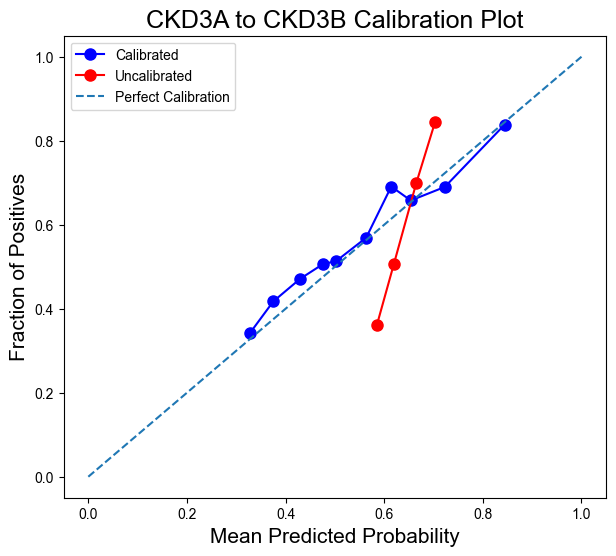

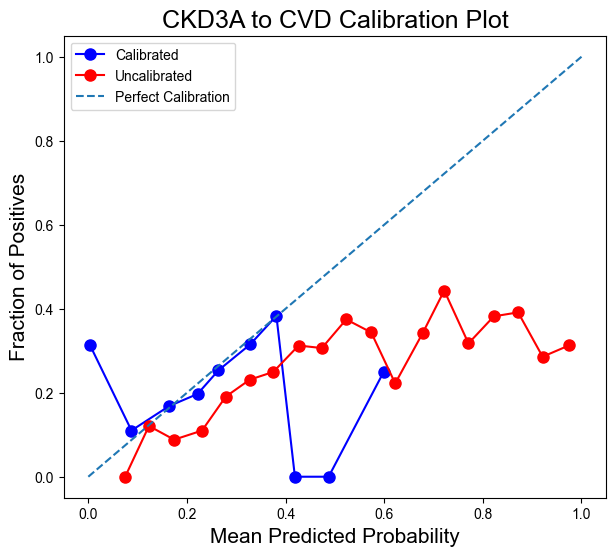

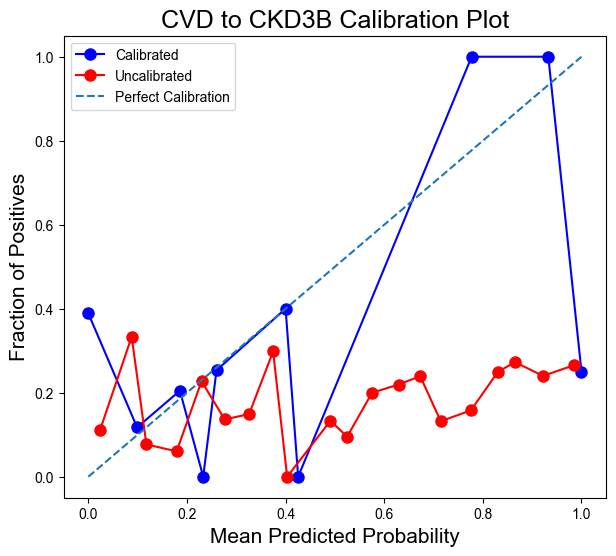

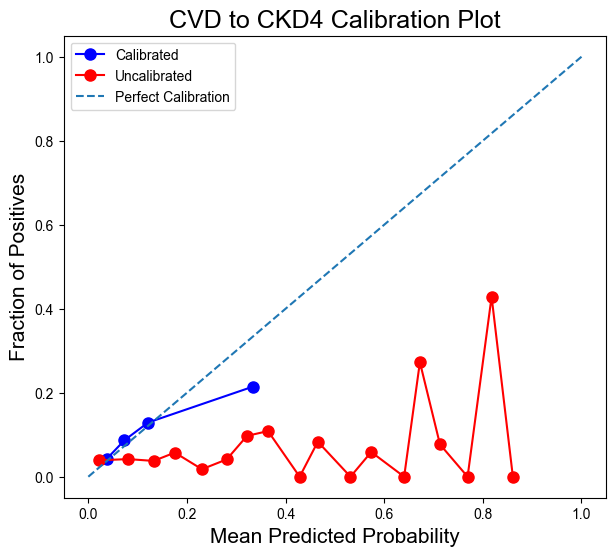

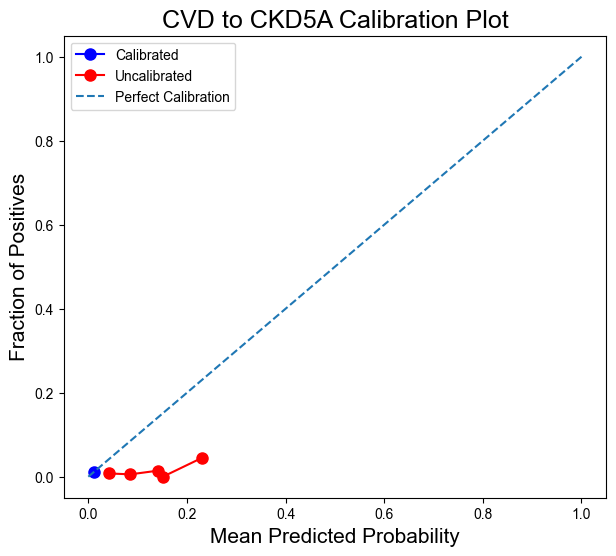

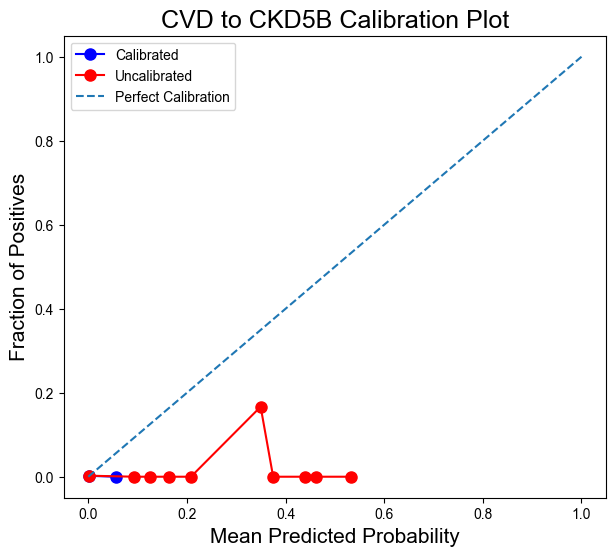

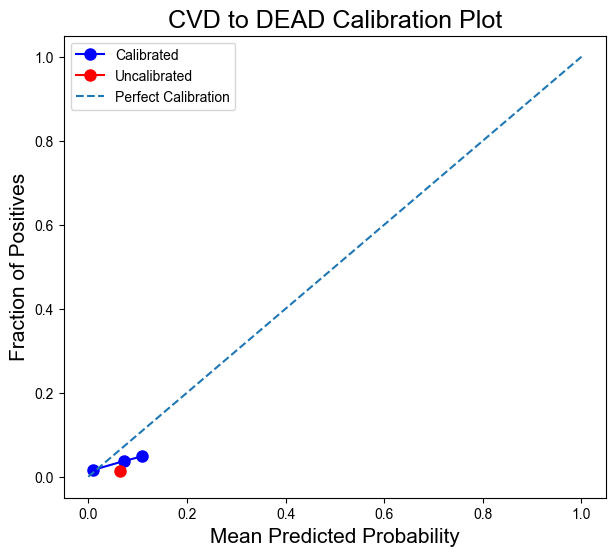

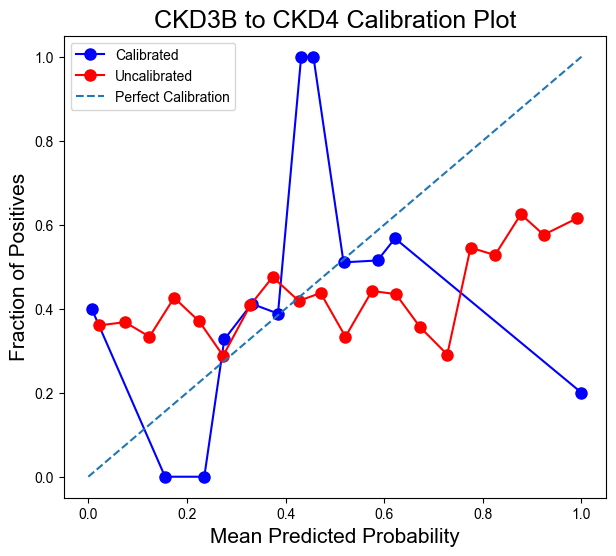

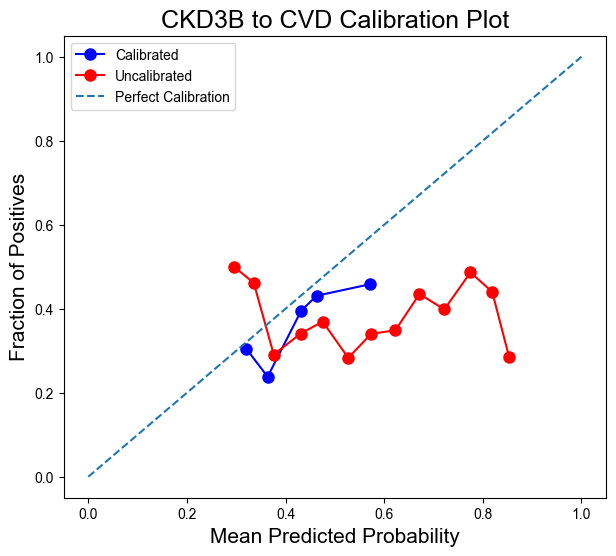

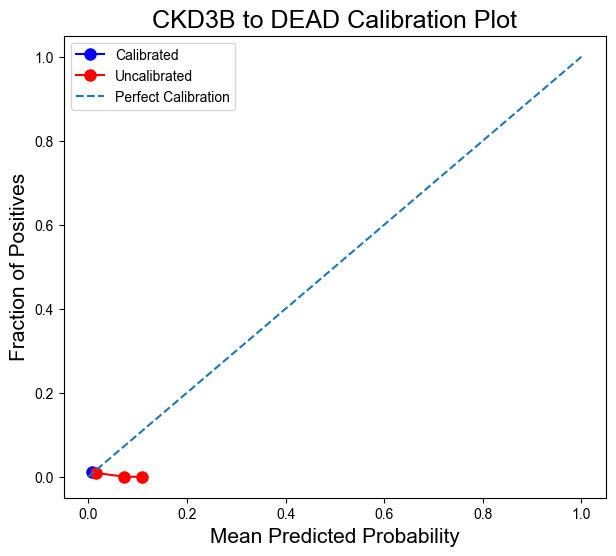

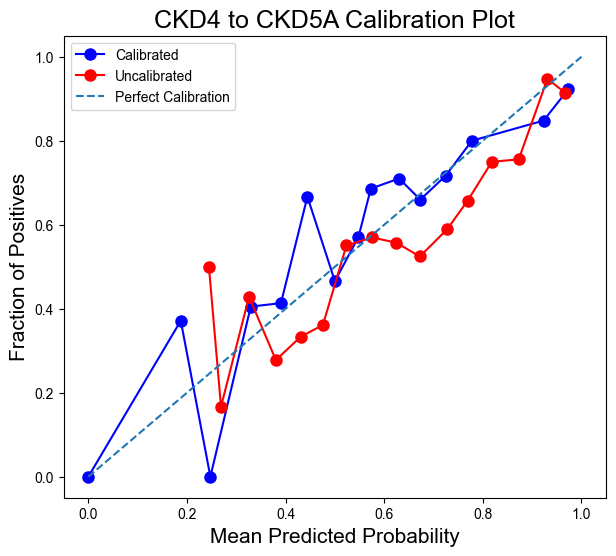

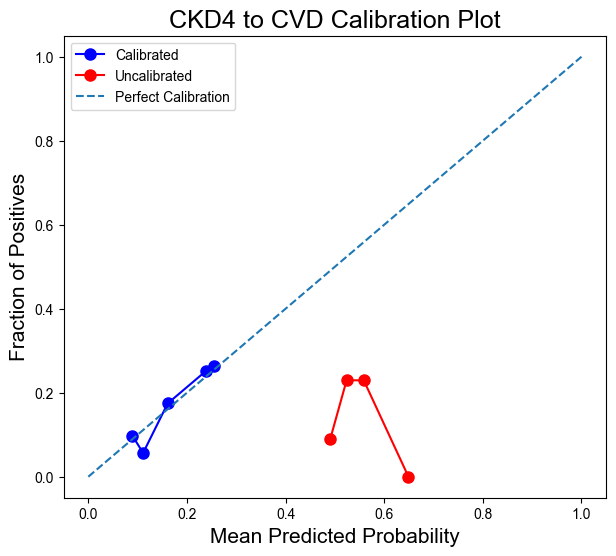

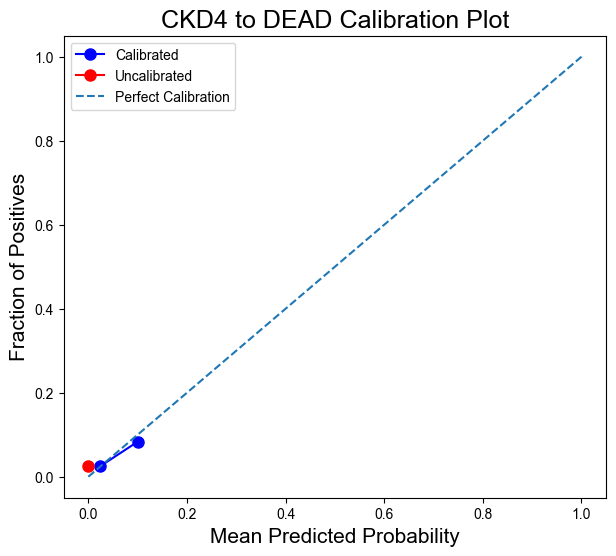

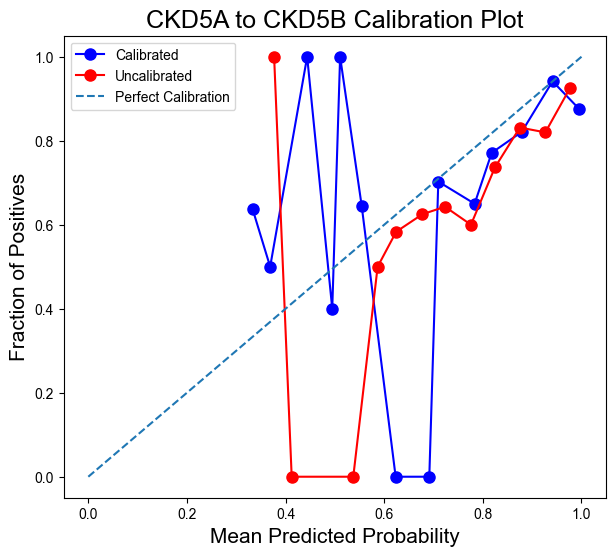

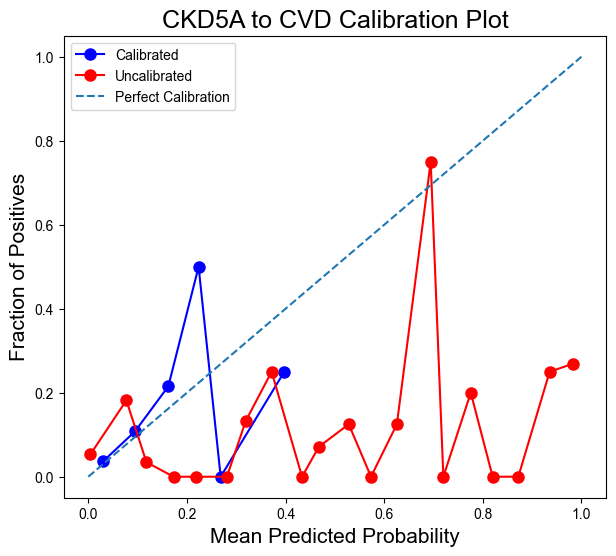

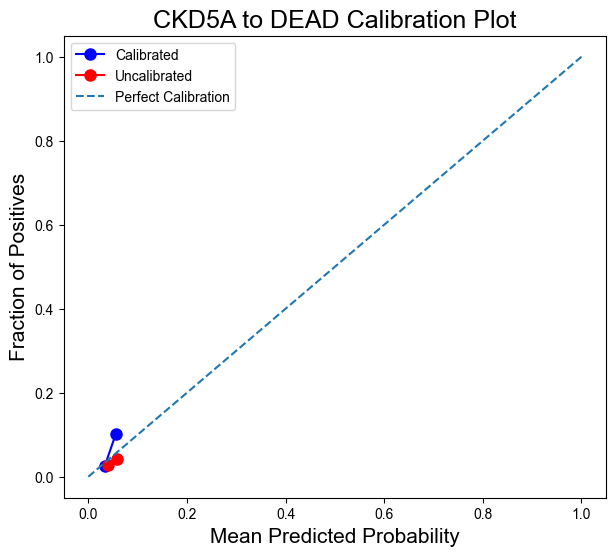

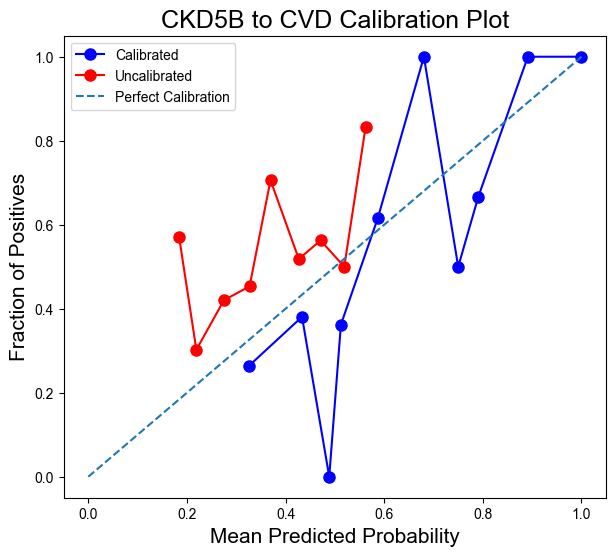

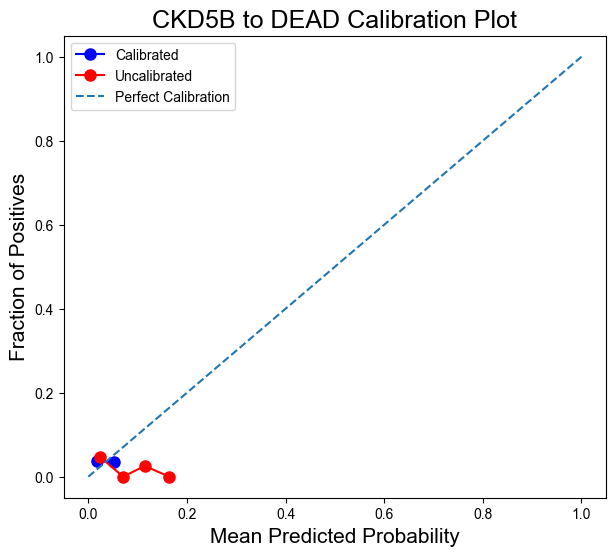

In [4]:
get_variance_inflation, get_interaction = False, False
get_importance = True
use_conformal  = True
use_platt = False
save_variance = True

folder_name = '24December2024_v2'
main_gradient_boost(folder_name, get_variance_inflation, get_interaction, get_importance, use_conformal, use_platt, save_variance)